In [149]:
import yfinance
import keras 
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [150]:
BTC = yfinance.download(tickers='BTC-USD', period='5y', interval='1d', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [151]:
BTC.index.unique()

DatetimeIndex(['2020-08-16', '2020-08-17', '2020-08-18', '2020-08-19',
               '2020-08-20', '2020-08-21', '2020-08-22', '2020-08-23',
               '2020-08-24', '2020-08-25',
               ...
               '2025-08-07', '2025-08-08', '2025-08-09', '2025-08-10',
               '2025-08-11', '2025-08-12', '2025-08-13', '2025-08-14',
               '2025-08-15', '2025-08-16'],
              dtype='datetime64[ns]', name='Date', length=1827, freq=None)

In [152]:
BTC = pd.DataFrame(
    BTC['Close'],
    index=BTC.index,
    columns=['BTC-USD']
)

<Axes: xlabel='Date'>

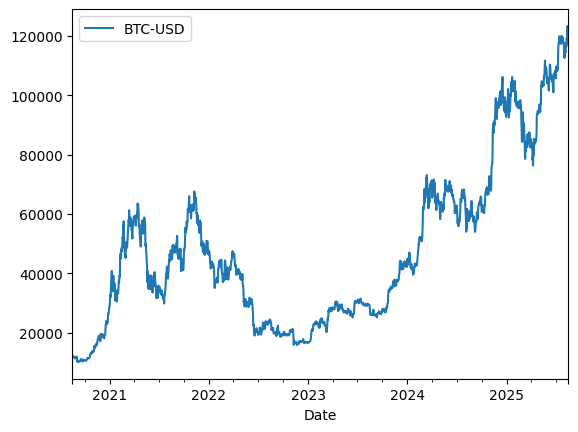

In [153]:
BTC.plot()

In [154]:
BTC.shape

(1827, 1)

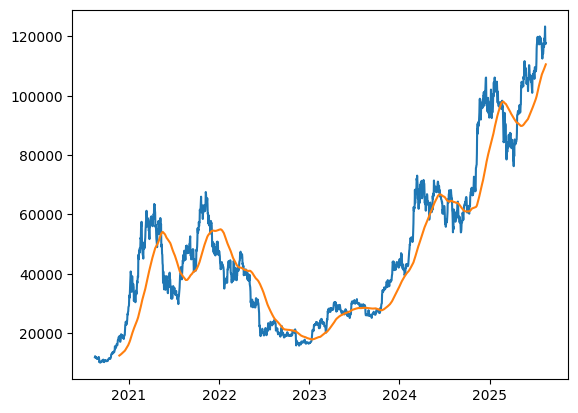

In [155]:
plt.plot(BTC['BTC-USD'])
plt.plot(BTC['BTC-USD'].rolling(100).mean())
plt.show()

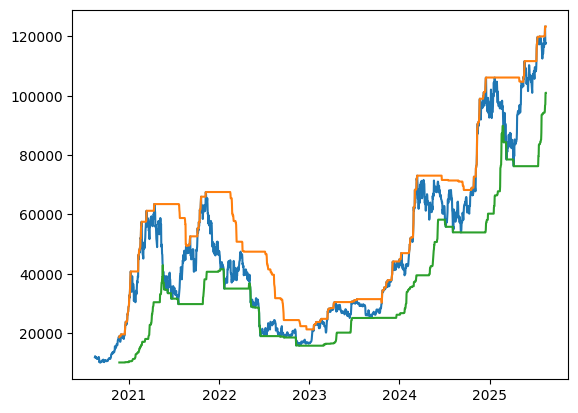

In [156]:
plt.plot(BTC['BTC-USD'])
plt.plot(BTC['BTC-USD'].rolling(100).max())
plt.plot(BTC['BTC-USD'].rolling(100).min())
plt.show()

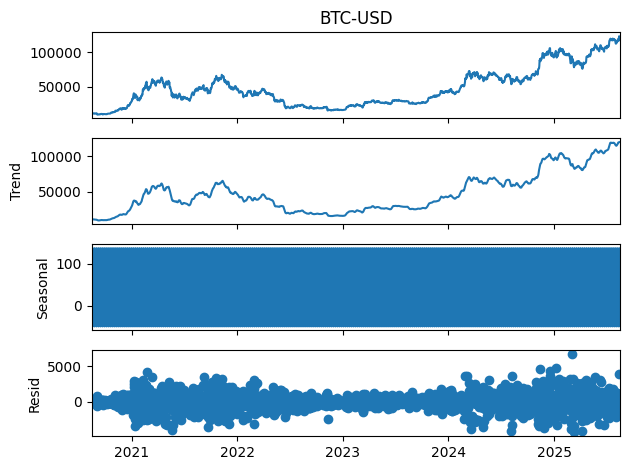

In [157]:
# Decompose

sm.tsa.seasonal_decompose(BTC['BTC-USD'], model='additive').plot()
plt.show()

Downsampling

In [158]:
BTC.reset_index(inplace=True)

In [159]:
BTC['mes'] = pd.to_datetime(BTC['Date']).dt.month_name('pt')

In [160]:
BTC['ano'] = pd.to_datetime(BTC['Date']).dt.year

In [161]:
BTC

,Date,BTC-USD,mes,ano
0,2020-08-16,11892.803711,Agosto,2020
1,2020-08-17,12254.402344,Agosto,2020
2,2020-08-18,11991.233398,Agosto,2020
3,2020-08-19,11758.283203,Agosto,2020
4,2020-08-20,11878.372070,Agosto,2020
...,...,...,...,...
1822,2025-08-12,120172.906250,Agosto,2025
1823,2025-08-13,123344.062500,Agosto,2025
1824,2025-08-14,118359.578125,Agosto,2025
1825,2025-08-15,117398.351562,Agosto,2025


In [162]:
subset = BTC.groupby(['ano','mes'])['Date'].max()
subset

ano   mes     
2020  Agosto     2020-08-31
      Dezembro   2020-12-31
      Novembro   2020-11-30
      Outubro    2020-10-31
      Setembro   2020-09-30
                    ...    
2025  Janeiro    2025-01-31
      Julho      2025-07-31
      Junho      2025-06-30
      Maio       2025-05-31
      Março      2025-03-31
Name: Date, Length: 61, dtype: datetime64[ns]

In [163]:
down_BTC = BTC.merge(subset, how='inner', on='Date')

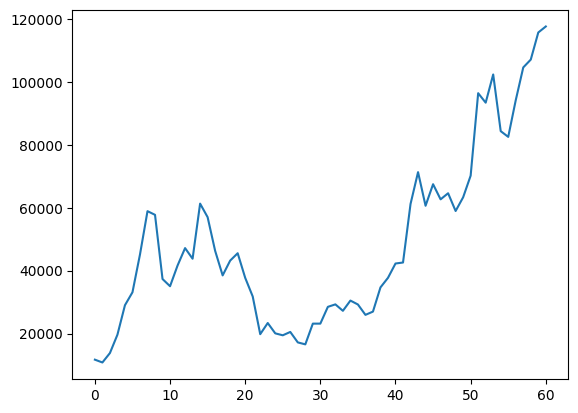

In [164]:
plt.plot(down_BTC['BTC-USD'])
plt.show()

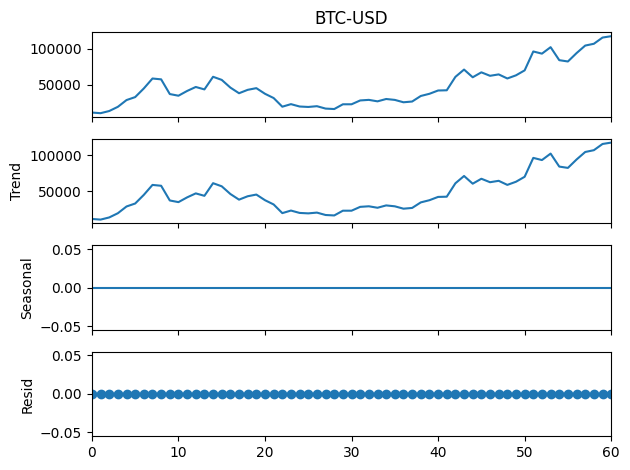

In [165]:
sm.tsa.seasonal_decompose(down_BTC['BTC-USD'], model='additive', period=1).plot()
plt.show()

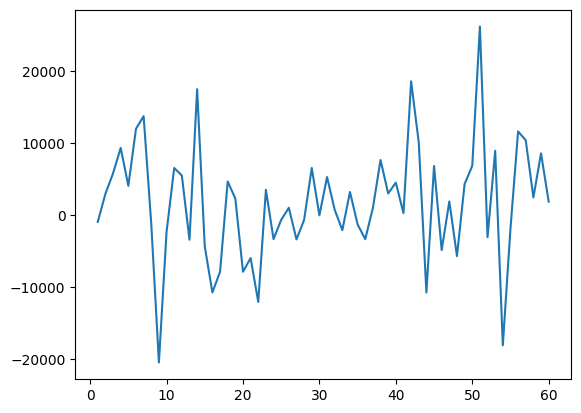

In [166]:
plt.plot(down_BTC['BTC-USD'].diff())

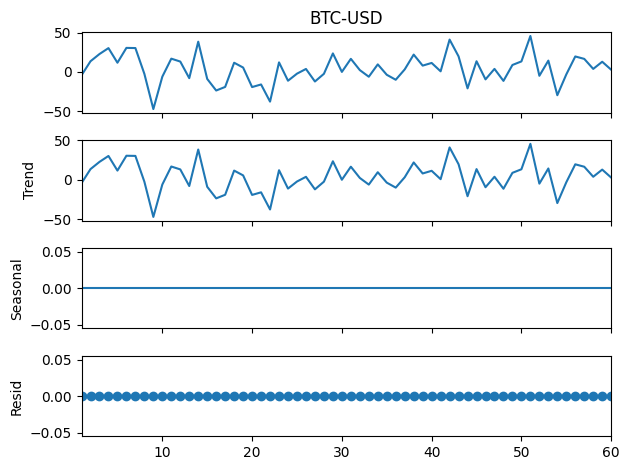

In [167]:
sm.tsa.seasonal_decompose(down_BTC['BTC-USD'].apply(np.sqrt).diff().dropna(), model='additive', period=1).plot()
plt.show()

In [168]:
def prepare_data(x, win, h, model_name='fc_model'):

    x = x.reshape(-1, 1)
    # Normalizando os dados
    x = (x - np.mean(x, axis=0, dtype=np.float32)) / np.std(x, axis=0, dtype=np.float32)

    if model_name == 'fc_model': ## NC data
        X = np.hstack([x[1:-h], x[0:-(h+1)]], dtype=np.float32)
        y = x[h:]

        return X, y
    else: ## TNC data
        X = np.zeros((x.shape[0] - win - h, win, x.shape[1]),  dtype=np.float32)
        y = np.zeros((x.shape[0] - win - h, x.shape[1]),  dtype=np.float32)

        for i in range(win, x.shape[0] - h):
            X[i-win] = x[(i - win):i, :]   # janela de tamanho 'win'
            y[i-win] = x[i + h - 1, :]     # target deslocado por h
        return X, y

In [169]:
def prepare_iter(X, y):


    n_train = int(y.shape[0] * 0.2)

    xtrain, xtest = (
        X[:n_train],
        X[n_train:]
    )

    ytrain, ytest = (
        y[:n_train],
        y[n_train:]
    )

    return (xtrain, ytrain), (xtest, ytest)

In [170]:
X, y = prepare_data(down_BTC['BTC-USD'].values, 10, 3, 'a')

In [171]:
(xtrain, ytrain), (xtest, ytest) = prepare_iter(X, y)

In [172]:
model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    keras.layers.LSTM(100),
    keras.layers.Dense(1)
])

c:\Users\mateu\Documents\Norton\Projetos GIT\livro-analise-pratica-series-temporais\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [173]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss='mse',
    metrics=['mae']
)

In [174]:
history = model.fit(
    xtrain,
    ytrain,
    epochs=100,
    validation_data=(xtest, ytest)
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0743 - mae: 0.2368 - val_loss: 1.2273 - val_mae: 0.9695
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0740 - mae: 0.2364 - val_loss: 1.2335 - val_mae: 0.9718
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0737 - mae: 0.2360 - val_loss: 1.2398 - val_mae: 0.9741
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0734 - mae: 0.2356 - val_loss: 1.2461 - val_mae: 0.9764
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0731 - mae: 0.2352 - val_loss: 1.2523 - val_mae: 0.9786
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0728 - mae: 0.2347 - val_loss: 1.2585 - val_mae: 0.9808
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0725 - mae: 0.2343 - val_loss: 1.2647 - val_mae: 0.9830
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0722 - mae: 0.2338 - val_loss: 1.2708 - val_mae: 0.9851
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0719 -

<Axes: >

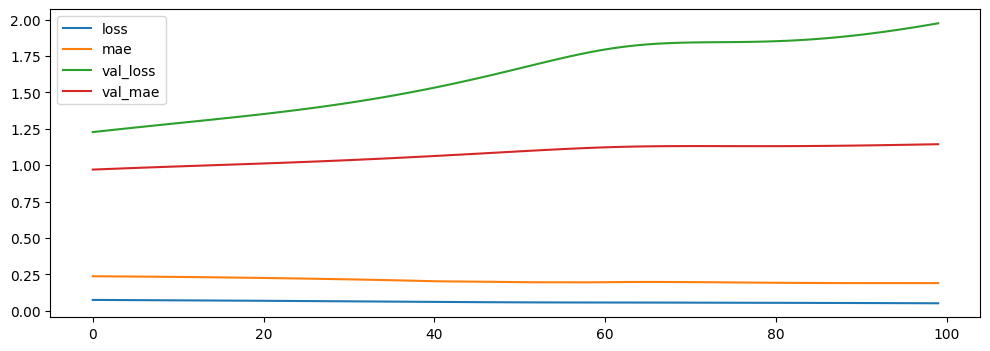

In [175]:
pd.DataFrame(history.history).plot(figsize=(12, 4))

In [176]:
best_arima = None
best_bic = np.inf
for p in range(1, 10):
    for i in range(1, 10):
        for q in range(1, 10):
            arima = sm.tsa.ARIMA(down_BTC['BTC-USD'], order=(p, i, q))
            if arima.fit().bic < best_bic:
                best_bic = arima.fit().bic
                best_arima = arima

c:\Users\mateu\Documents\Norton\Projetos GIT\livro-analise-pratica-series-temporais\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\mateu\Documents\Norton\Projetos GIT\livro-analise-pratica-series-temporais\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\mateu\Documents\Norton\Projetos GIT\livro-analise-pratica-series-temporais\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\mateu\Documents\Norton\Projetos GIT\livro-analise-pratica-series-temporais\.venv\Lib\site-pack

LinAlgError: LU decomposition error.

In [177]:
best_arima.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                BTC-USD   No. Observations:                   61
Model:                 ARIMA(1, 5, 3)   Log Likelihood                -604.540
Date:                Sat, 16 Aug 2025   AIC                           1219.079
Time:                        18:32:23   BIC                           1229.206
Sample:                             0   HQIC                          1223.005
                                 - 61                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4087      0.115     -3.548      0.000      -0.634      -0.183
ma.L1         -2.9600      0.430     -6.885      0.000      -3.803      -2.117
ma.L2          2.9592      0.433      6.833      0.000       2.110       3.808
ma.L3         -0.9992      0.196     -5.110      0.000      -1.382      -0.616
sigma2      1.124e+08   9.71e-09   1.16e+16      0.000    1.12e+08    1.12e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.56   Prob(JB):                         0.94
Heteroskedasticity (H):               1.14   Skew:                             0.10
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.52e+31. Standard errors may be unstable.
"""

In [178]:
pred = best_arima.fit().predict(start=len(down_BTC), end=len(down_BTC)+30)

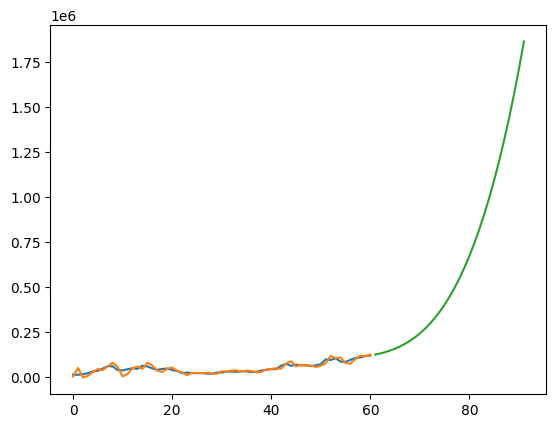

In [179]:
plt.plot(down_BTC['BTC-USD'])
plt.plot(best_arima.fit().fittedvalues)
plt.plot(range(len(down_BTC), len(down_BTC)+31), pred)

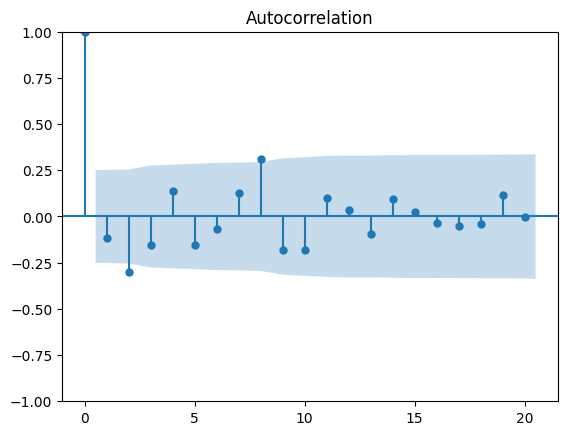

In [180]:
# acf 
sm.graphics.tsa.plot_acf(best_arima.fit().resid, lags=20)
plt.show()

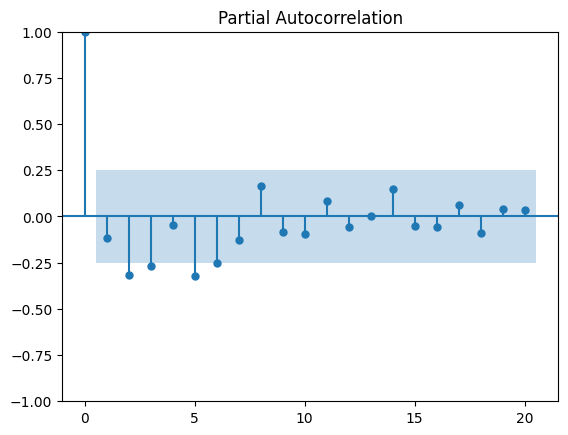

In [181]:
#pacf
sm.graphics.tsa.plot_pacf(best_arima.fit().resid, lags=20)
plt.show()

In [182]:
x = BTC['BTC-USD'].diff().dropna().values.reshape(-1, 1)

X, y = prepare_data(x, 10, 3, 'a')
(xtrain, ytrain), (xtest, ytest) = prepare_iter(X, y)
model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    keras.layers.LSTM(100),
    keras.layers.Dense(1)
])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss='mse',
    metrics=['mae']
)
history = model.fit(
    xtrain,
    ytrain,
    epochs=10,
    validation_data=(xtest, ytest)
)

Epoch 1/10


c:\Users\mateu\Documents\Norton\Projetos GIT\livro-analise-pratica-series-temporais\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 1.1234 - mae: 0.7049 - val_loss: 0.9789 - val_mae: 0.6433
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.1208 - mae: 0.7040 - val_loss: 0.9789 - val_mae: 0.6439
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.1209 - mae: 0.7040 - val_loss: 0.9791 - val_mae: 0.6444
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.1203 - mae: 0.7037 - val_loss: 0.9792 - val_mae: 0.6447
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.1201 - mae: 0.7036 - val_loss: 0.9792 - val_mae: 0.6446
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.1199 - mae: 0.7035 - val_loss: 0.9794 - val_mae: 0.6451
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.1206 - mae: 0.7036 - val_loss: 0.9796 - val_mae: 0.6453
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.1198 - mae: 0.7034 - val_loss: 0.9796 - val_mae: 0.6453
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.1202 - mae: 0.

In [184]:
pred_real = np.cumsum(model.predict(xtest)) + BTC['BTC-USD'].iloc[0]
ytes  = np.cumsum(ytest) + BTC['BTC-USD'].iloc[0]

pred_real_train = np.cumsum(model.predict(xtrain)) + BTC['BTC-USD'].iloc[0]
ytrat = np.cumsum(ytrain) + BTC['BTC-USD'].iloc[0]

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
